## Predicting Customer Retention -- Fader and Hardie, 2005 
Tristan Eisenhart

In [1]:
import numpy as np
from scipy.optimize import minimize
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

Trying to model the shifted beta geometric distribution to predict survivor rate of customers -- using the dataset from the paper "How to Project Customer Retention" from Fader and Hardie. Let's use 3 different methods to do so. Method (1) uses a maximum likelihood estimator, Method (2) uses the tradtional OLS optimization, and Method (3) uses a vanilla Neural Network with 32 nodes / 2 hidden layers. 

At the end of the notebook, I am plotting all results together on one single graph.

In [20]:
alpha, beta = 1, 1 # initial values for alpha and beta
quit = np.array([0.131,0.126,0.09,0.06,0.042,0.034,0.026]) # output, which represent the % of users who quit
# at each time period
T = 7 # Length of training set, i.e. how many years of training we want to use

In [21]:
def lifetime(alpha, beta, T):
    
    '''Calculating the Probability of having a customer lifetime of T = t '''
    
    if T <= 1:
        lifetime_P = np.array([alpha/(alpha+beta)])
    else:
        lifetime_P = np.array([alpha/(alpha+beta)])
        for t in range(2,T+1):
            temp = lifetime_P[t-2] * (beta + t - 2) / (alpha + beta + t - 1)
            lifetime_P = np.append(lifetime_P, temp)
    return lifetime_P

def survivor(lifetime_P, T):
    
    '''Calculating the Probability that a customer survives until time t'''
    
    if T <= 1:
        survivor_P = np.array([1-lifetime_P])
    else:
        survivor_P = np.array([1-lifetime_P[0]])
        for t in range(2,T+1):
            temp = survivor_P[t-2] - lifetime_P[t-1]
            survivor_P = np.append(survivor_P, temp)
    return survivor_P

### Method 1: LL -- Maximizing the log-likelihood

In [22]:
def loglikelihood(alpha, beta, quit, T):
    
    '''Log-Likelihood function to represent the data'''
    
    lifetime_P = lifetime(alpha, beta, T)
    survivor_P = survivor(lifetime_P, T)
    loglikelihood_array = np.log(lifetime_P) * quit
    remaining = (1-np.sum(quit)) * np.log(survivor_P[T-1])
    loglikelihood_array = np.append(loglikelihood_array,remaining)
    return np.sum(loglikelihood_array)

def optimizer_ll():
    
    '''useful link https://gist.github.com/jdmaturen/6958459 for minimization function'''
    
    function = lambda x: -loglikelihood(x[0],x[1], quit, T)
    optimum = minimize(function, np.array([1.,1.]), method='nelder-mead', options={'xtol': 1e-8})
    return optimum

results_ll = optimizer_ll()
alpha_star_ll, beta_star_ll = results_ll.x[0], results_ll.x[1]
lifetime_P_forecast_ll = lifetime(alpha_star_ll, beta_star_ll, 12)
survivor_P_forecast_ll = survivor(lifetime_P_forecast_ll, 12)

/Users/tristaneisenhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log


### Method 2: OLS -- Minimizing the root mean square error

In [5]:
def MSE(alpha, beta, quit, T):
    
    lifetime_P = lifetime(alpha, beta, T)
    survivor_P = survivor(lifetime_P, T)
    MSE_array = np.square(lifetime_P - quit)
    return np.sqrt(np.sum(MSE_array))

def optimizer_OLS():
    
    function = lambda x: MSE(x[0], x[1], quit, T)
    optimum = minimize(function, np.array([1.,1.]), method='nelder-mead', options={'xtol': 1e-8})
    return optimum

results_OLS = optimizer_OLS()
alpha_star_OLS, beta_star_OLS = results_OLS.x[0], results_OLS.x[1]
lifetime_P_forecast_OLS = lifetime(alpha_star_OLS, beta_star_OLS, 12)
survivor_P_forecast_OLS = survivor(lifetime_P_forecast_OLS, 12)

### Method 3: Vanilla Neural Network -- Approximating the output using activation function / NN

In [6]:
# putting data into dataframe
df = pd.DataFrame({'survivor':quit, 't': list(range(1,T+1))})

Defining Graph

In [12]:
'''Code comes from my github account, https://github.com/TristanEis007/machine-learning'''

# Resetting to default graph -- especially usefull when running multiple sessions
tf.reset_default_graph()

# Declaring parameters / architecture of neural network
num_input_features = 1
num_hidden_nodes = 32
num_classes = 1
learning_rate = 0.001
seed = 7

# Declaring placeholders for input data and true outputs
inputs = tf.placeholder(tf.float32, shape=[None, num_input_features])
true_outputs = tf.placeholder(tf.float32, shape=[None, 1])

# Randomely initializing weights and biases using normal distribution
weights = {
    'hidden': tf.Variable(tf.random_normal([num_input_features, num_hidden_nodes], seed=seed)),
    'hidden_2': tf.Variable(tf.random_normal([num_hidden_nodes, num_hidden_nodes], seed=seed)),
    'output': tf.Variable(tf.random_normal([num_hidden_nodes, num_classes], seed=seed))}

biases = {
    'hidden': tf.Variable(tf.random_normal([num_hidden_nodes], seed=seed)),
    'hidden_2': tf.Variable(tf.random_normal([num_hidden_nodes], seed=seed)),
    'output': tf.Variable(tf.random_normal([num_classes], seed=seed))}

layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(inputs,weights['hidden']),biases['hidden']))
layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1,weights['hidden_2']),biases['hidden_2']))
output_layer = tf.nn.sigmoid(tf.add(tf.matmul(layer_2,weights['output']),biases['output']))
error = tf.subtract(output_layer, true_outputs)
mean_square_error = tf.reduce_sum(tf.square(error))
train = tf.train.GradientDescentOptimizer(learning_rate).minimize(mean_square_error)

Running graph

In [13]:
sess = tf.Session()

# Initializing all variables - you need to initialize your variables before running your graph
init = tf.global_variables_initializer()
sess.run(init)

# Let's limit the number of iterations 
iter_ = 0
print("Starting optimization")

while iter_ <= 1000000:

    '''note that we want the output produced to be as close to the quit array'''
    _ = sess.run(train, feed_dict={inputs:np.array(df[['t']]),true_outputs:np.array(df[['survivor']])})
    
    # Evaluating the Mean Squared Error
    mse = sess.run(mean_square_error, feed_dict={inputs:np.array(df[['t']]),true_outputs:np.array(df[['survivor']])})
    
    # Displaying results every 50000 iterations
    if iter_ % 250000 == 0:
        # Evaluating the output layer -- what is predicted for each observation
        out = sess.run(output_layer, feed_dict={inputs:np.array(df[['t']])})
        
        # Displaying the mean square error
        print("Iteration:",iter_, "Mean_square_error:", mse,"\nOutput\n", out)
    
    iter_ += 1

print("Very cool, we are finished with the optimiztion!")

Starting optimization
Iteration: 0 Mean_square_error: 5.91805 
Output
 [[ 0.99490488]
 [ 0.99260545]
 [ 0.99127603]
 [ 0.9906255 ]
 [ 0.99029279]
 [ 0.9900682 ]
 [ 0.98986065]]
Iteration: 250000 Mean_square_error: 0.00119222 
Output
 [[ 0.14608015]
 [ 0.10208471]
 [ 0.0780464 ]
 [ 0.06161385]
 [ 0.05013633]
 [ 0.04218756]
 [ 0.03668339]]
Iteration: 500000 Mean_square_error: 0.000676442 
Output
 [[ 0.14404555]
 [ 0.10729291]
 [ 0.0822645 ]
 [ 0.06283971]
 [ 0.04845248]
 [ 0.03830865]
 [ 0.03131028]]
Iteration: 750000 Mean_square_error: 0.000477285 
Output
 [[ 0.14226712]
 [ 0.10983415]
 [ 0.08454338]
 [ 0.06358612]
 [ 0.04768268]
 [ 0.03646646]
 [ 0.02882675]]
Iteration: 1000000 Mean_square_error: 0.000374988 
Output
 [[ 0.14104138]
 [ 0.111459  ]
 [ 0.08592889]
 [ 0.06393673]
 [ 0.04713361]
 [ 0.0353949 ]
 [ 0.02753177]]
Very cool, we are finished with the optimiztion!


In [14]:
# Predicting over the period 8-12
all_ = pd.DataFrame({'t':[8,9,10,11,12]})
survivor_NN = sess.run(output_layer, feed_dict={inputs:np.array(all_[['t']])})
all_['survivor'] = survivor_NN
all_ = all_.append(df)
all_ = all_.sort_values(by='t')
all_['lifetime_P'] = all_['survivor']
all_['survivor'] = 1 - all_['lifetime_P']
for i in range(0,len(all_)):
    all_['survivor'] = all_.apply(lambda x: all_.iloc[int(x['t']-2)]['survivor']-x['lifetime_P'] if x['t']>1 else x['survivor'], axis=1)
all_.reset_index(drop=True,inplace=True)

### Plotting true values versus model results

In [15]:
true = np.array([0.869, 0.743, 0.653, 0.593, 0.551, 0.517, 0.491, 0.468, 0.445, 0.427, 0.409, 0.394])

/Users/tristaneisenhart/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


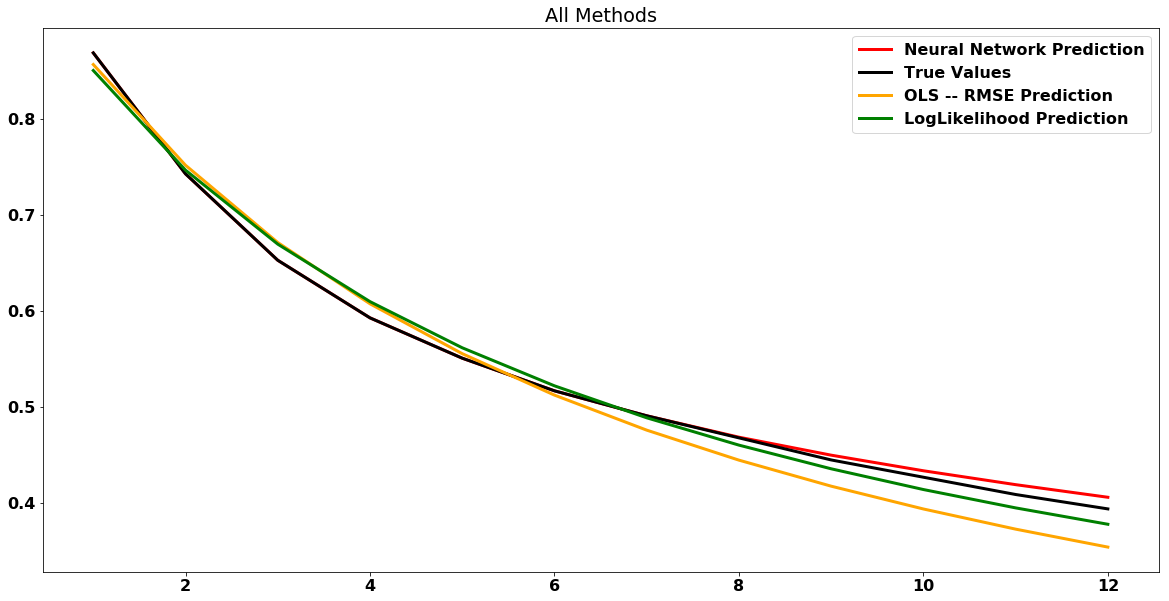

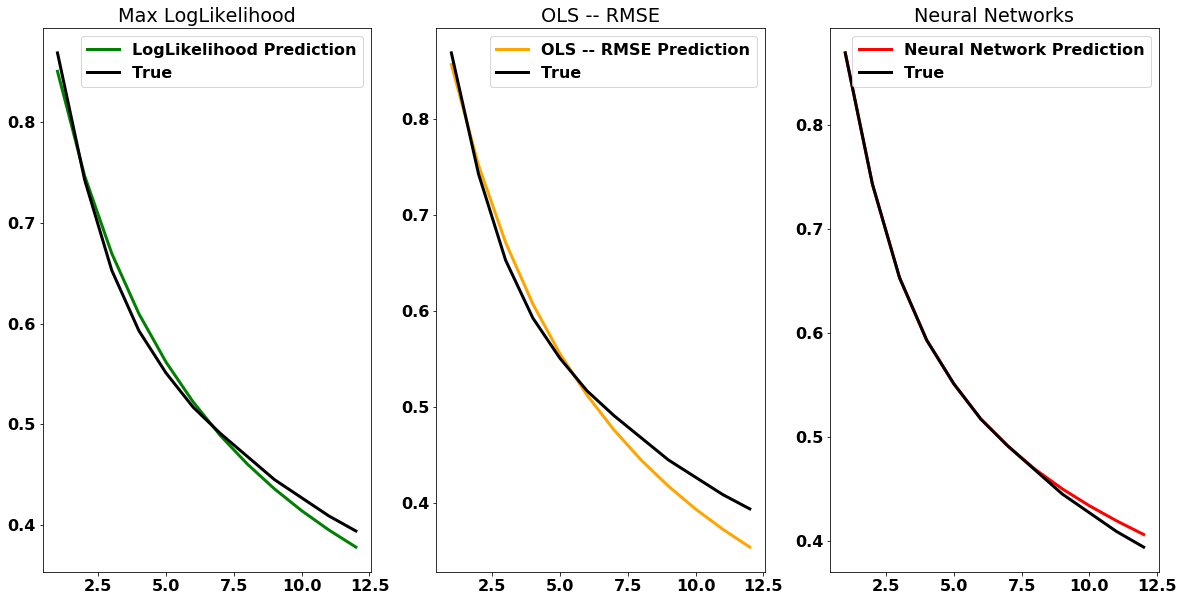

In [19]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.plot(all_['t'],all_['survivor'], label='Neural Network Prediction', color='Red', linewidth=3)
ax1.plot(all_['t'],true, label='True Values', linewidth=3, color='Black')
ax1.plot(all_['t'],survivor_P_forecast_OLS,label='OLS -- RMSE Prediction', linewidth=3, color='Orange')
ax1.plot(all_['t'],survivor_P_forecast_ll, label='LogLikelihood Prediction', linewidth=3, color='Green')
ax1.set_title("All Methods")
ax1.legend()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(131)
ax1.plot(all_['t'],survivor_P_forecast_ll, label='LogLikelihood Prediction',  linewidth=3, color='Green')
ax1.plot(all_['t'],true, label='True', linewidth=3, color='Black')
ax1.set_title("Max LogLikelihood")
ax1.legend()
ax2 = fig.add_subplot(132)
ax2.plot(all_['t'],survivor_P_forecast_OLS,  label='OLS -- RMSE Prediction', linewidth=3, color='Orange')
ax2.plot(all_['t'],true, label='True', linewidth=3, color='Black')
ax2.set_title("OLS -- RMSE")
ax2.legend()
ax3 = fig.add_subplot(133)
ax3.plot(all_['t'],all_['survivor'], label='Neural Network Prediction', color='Red', linewidth=3)
ax3.plot(all_['t'],true, label='True', linewidth=3, color='Black')
ax3.set_title("Neural Networks")
ax3.legend()

In [17]:
print("MSE of the LL Method:",np.sum(np.square(survivor_P_forecast_ll-true)))
print("MSE of OLS Method:",np.sum(np.square(survivor_P_forecast_OLS-true)))
print("MSE of NN Method:",np.sum(np.square(np.array(all_['survivor'])-true)))

MSE of the LL Method: 0.00182484288307
MSE of OLS Method: 0.00631162118591
MSE of NN Method: 0.000322543304118


From the graphs and evaluated MSEs, we see that the Neural Network approach approximates best the underlying function. The LogLikelihood estimation does a better work to approximate the true alpha and beta parameters of the shifted beta geometric underlying distribution, compared to the OLS method. 

It's interesting to note that the Neural Network, after 1,000,000 training iterations starts to overestimate the retention rate of customers, whereas other methods underestimate this rate. 

Great article and fun way to predict churn! 